<h1>Softmax Regression on MNIST</h1>

<h3>Imports</h3>

In [3]:
import torch
import time
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<h3>Preprocessing the data</h3>

In [5]:
# normalizing the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


<h3>Downloading the dataset</h3>

In [6]:
train_val_dataset = datasets.MNIST(root='./dataset', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='./dataset', train=False, download=False, transform=transform)
combined_dataset = ConcatDataset([train_val_dataset, test_dataset])


In [7]:
print(f"Train dataset size: {len(train_val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Combined dataset size: {len(combined_dataset)}")

Train dataset size: 60000
Test dataset size: 10000
Combined dataset size: 70000


In [8]:
# print(combined_dataset[0][0].shape)
# print(combined_dataset[0][1])
# x, y= combined_dataset[0]
# print(x.shape)
# print("x= ", x)
# print(y)
# plt.imshow(x[0], cmap='gray')

<h3>HyperParameters</h3>

In [16]:
batch_size = 64
learning_rate = 0.01
num_classes = 10
input_size = 28 * 28

<h3>Splitting the data</h3>

In [10]:
#calculating split sizes
train_datset_size = int(0.6 * len(combined_dataset))
val_dataset_size = int(0.2 * len(combined_dataset))
test_dataset_size = len(combined_dataset) - train_datset_size - val_dataset_size

#printing split sizes
print(train_datset_size, val_dataset_size, test_dataset_size)

42000 14000 14000


In [11]:
# splitting the dataset
train_dataset_idx, temp_dataset_idx = train_test_split(list(range(len(combined_dataset))), train_size=train_datset_size, random_state=5)
val_dataset_idx, test_dataset_idx = train_test_split(temp_dataset_idx, test_size=0.5, random_state=5)

print(len(train_dataset_idx), len(val_dataset_idx), len(test_dataset_idx))

42000 14000 14000


In [12]:
train_dataset = Subset(combined_dataset, train_dataset_idx)
val_dataset = Subset(combined_dataset, val_dataset_idx)
test_dataset = Subset(combined_dataset, test_dataset_idx)

print(len(train_dataset), len(val_dataset), len(test_dataset))

42000 14000 14000


In [13]:
# creating dataloaders
train_dataset_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataset_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_dataset_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print(len(train_dataset_loader), len(val_dataset_loader), len(test_dataset_loader))

657 219 219


In [14]:
x, y = next(iter(train_dataset_loader))

print(x.shape)
print(y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


<h3>Softmax Regression Model</h3>

Epoch 1/10
Training Loss: 0.6799
Validation Loss: 0.4474
Validation Accuracy: 0.8808
Epoch 2/10
Training Loss: 0.4119
Validation Loss: 0.3881
Validation Accuracy: 0.8915
Epoch 3/10
Training Loss: 0.3695
Validation Loss: 0.3664
Validation Accuracy: 0.8928
Epoch 4/10
Training Loss: 0.3469
Validation Loss: 0.3431
Validation Accuracy: 0.9006
Epoch 5/10
Training Loss: 0.3340
Validation Loss: 0.3459
Validation Accuracy: 0.9007
Epoch 6/10
Training Loss: 0.3234
Validation Loss: 0.3248
Validation Accuracy: 0.9069
Epoch 7/10
Training Loss: 0.3160
Validation Loss: 0.3285
Validation Accuracy: 0.9081
Epoch 8/10
Training Loss: 0.3100
Validation Loss: 0.3309
Validation Accuracy: 0.9028
Epoch 9/10
Training Loss: 0.3055
Validation Loss: 0.3189
Validation Accuracy: 0.9069
Epoch 10/10
Training Loss: 0.3010
Validation Loss: 0.3111
Validation Accuracy: 0.9084


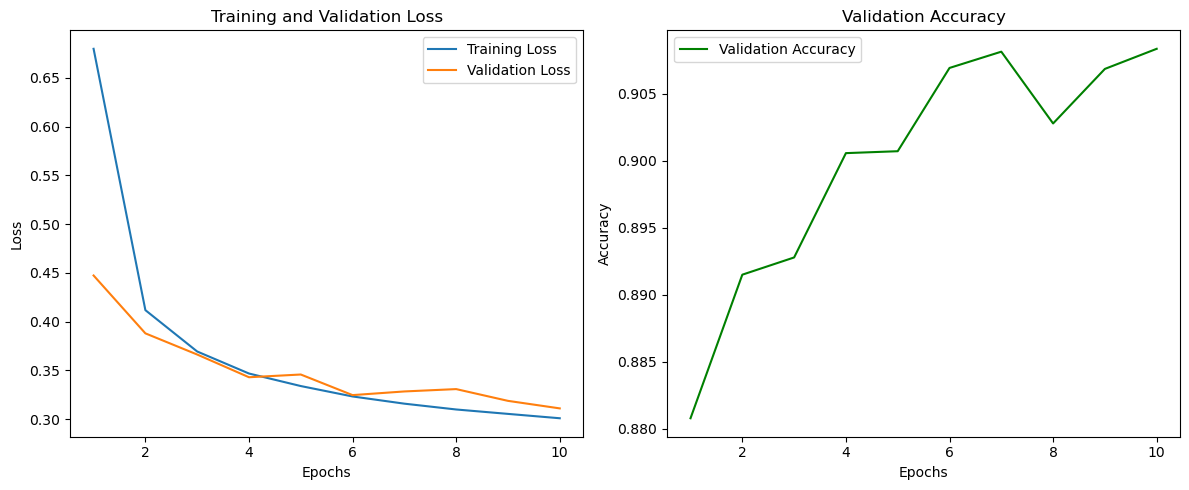

In [ ]:
# Defining the softmax regression model
class SoftmaxRegressionModel(torch.nn.Module):
    def __init__(self):
        super(SoftmaxRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(input_size, num_classes)  # MNIST images are 28x28 pixels, 10 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the images
        return self.linear(x)

# Initialize model, loss function, and optimizer
model = SoftmaxRegressionModel().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

# Training and evaluation
num_epochs = 10
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_loss = 0.0
    for batch_idx, (x_train, y_train) in enumerate(train_dataset_loader):
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dataset_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x_val, y_val in val_dataset_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()

    val_loss /= len(val_dataset_loader)
    val_losses.append(val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    # Logging
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

# Visualizations
epochs = range(1, num_epochs + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
